# COVID19DB PROJECT (www.covid19db.org): covid19 - confirmed cases, administrative division for Germany


This notebook demonstrates how to connect to COVID19db Postgres database and how to generate country level visualisaion.

In [8]:
import psycopg2
import pandas as pd
from pandas.plotting import register_matplotlib_converters 
register_matplotlib_converters()
import matplotlib.pyplot as plt

# Connect to covid19db.org
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19'
)

# Retrieving epidemiology data for single source

In [9]:
# Load all data for region 1
sql_command = """SELECT * FROM epidemiology WHERE source = %(source)s AND adm_area_1 <> '' ORDER by date DESC"""
df = pd.read_sql(sql_command, conn, params={'source': 'DEU_JPGG'})
df.head()

,source,date,country,countrycode,adm_area_1,adm_area_2,adm_area_3,tested,confirmed,recovered,dead,hospitalised,hospitalised_icu,quarantined,gid
0,DEU_JPGG,2020-05-23,Germany,DEU,Thüringen,None,None,None,2863,None,154,None,None,None,[DEU.16_1]
1,DEU_JPGG,2020-05-23,Germany,DEU,Schleswig-Holstein,None,None,None,3077,None,140,None,None,None,[DEU.15_1]
2,DEU_JPGG,2020-05-23,Germany,DEU,Sachsen-Anhalt,None,None,None,1700,None,54,None,None,None,[DEU.13_1]
3,DEU_JPGG,2020-05-23,Germany,DEU,Sachsen,None,None,None,5226,None,204,None,None,None,[DEU.14_1]
4,DEU_JPGG,2020-05-23,Germany,DEU,Saarland,None,None,None,2730,None,166,None,None,None,[DEU.12_1]


In [ ]:
# Extracting only recent data - total per region

In [11]:
df_recent = df.copy()
df_recent['gid'] = [','.join(map(str, l)) for l in df['gid']]
df_recent = df_recent.sort_values('date').groupby('adm_area_1').apply(lambda x: x.max())

df_recent = df_recent.set_index('date')
df_recent[["country", "adm_area_1", "confirmed", "recovered", "dead", "gid"]].head(30)

,country,adm_area_1,confirmed,recovered,dead,gid
date,,,,,,
2020-05-23,Germany,Baden-Württemberg,35307,None,1756,DEU.1_1
2020-05-23,Germany,Bayern,47100,None,2456,DEU.2_1
2020-05-23,Germany,Berlin,6611,None,191,DEU.3_1
2020-05-23,Germany,Brandenburg,3253,None,170,DEU.4_1
2020-05-23,Germany,Bremen,1301,None,39,DEU.5_1
2020-05-23,Germany,Hamburg,5055,None,240,DEU.6_1
2020-05-23,Germany,Hessen,9718,None,471,DEU.7_1
2020-05-23,Germany,Mecklenburg-Vorpommern,766,None,21,DEU.8_1
2020-05-23,Germany,Niedersachsen,11755,None,588,DEU.9_1


### Retrieving administrative division level 1 for single country from covid19db

In [12]:
# Get Covid19db administrative division
import geopandas as gpd
def get_administrative_division(level=0, countrycode=None):
    sql = f"SELECT * FROM administrative_division WHERE adm_level={level} "
    if level>0 and countrycode: 
        sql = sql +  f"AND countrycode='{countrycode}'"

    admin_data = gpd.GeoDataFrame.from_postgis(sql, conn, geom_col='geometry')
    admin_data["area"] = admin_data['geometry'].area
    return admin_data

In [13]:
admin_1_data = get_administrative_division(level=1, countrycode='DEU')
admin_1_data.head()

,country,countrycode,countrycode_alpha2,adm_level,adm_area_1,adm_area_1_code,adm_area_2,adm_area_2_code,adm_area_3,adm_area_3_code,gid,latitude,longitude,properties,geometry,area
0,Germany,DEU,DE,1,Baden-Württemberg,DEU.1_1,None,None,None,None,DEU.1_1,48.537460,9.049128,"{'CC_1': '08', 'GID_0': 'DEU', 'GID_1': 'DEU.1...","MULTIPOLYGON (((9.73705 47.61321, 9.70485 47.6...",4.395367
1,Germany,DEU,DE,1,Bayern,DEU.2_1,None,None,None,None,DEU.2_1,48.947574,11.419913,"{'CC_1': '09', 'GID_0': 'DEU', 'GID_1': 'DEU.2...","POLYGON ((9.74066 47.55354, 9.73523 47.53401, ...",8.664293
2,Germany,DEU,DE,1,Berlin,DEU.3_1,None,None,None,None,DEU.3_1,52.501532,13.401850,"{'CC_1': '11', 'GID_0': 'DEU', 'GID_1': 'DEU.3...","POLYGON ((13.17136 52.39776, 13.13099 52.38723...",0.119285
3,Germany,DEU,DE,1,Brandenburg,DEU.4_1,None,None,None,None,DEU.4_1,52.472884,13.397770,"{'CC_1': '12', 'GID_0': 'DEU', 'GID_1': 'DEU.4...","POLYGON ((12.70009 52.00265, 12.65650 52.01294...",3.922739
4,Germany,DEU,DE,1,Bremen,DEU.5_1,None,None,None,None,DEU.5_1,53.197717,8.744642,"{'CC_1': '04', 'GID_0': 'DEU', 'GID_1': 'DEU.5...","MULTIPOLYGON (((8.71142 53.04463, 8.70906 53.0...",0.052417


# Merge administrative division and epidemiology data

In [15]:
data_pd = df_recent.merge(admin_1_data, how = 'outer', left_on = 'gid', right_on = 'gid', suffixes=('', '_y'))
data_pd = gpd.GeoDataFrame(data_pd, geometry='geometry')
data_pd.head()

,source,country,countrycode,adm_area_1,adm_area_2,adm_area_3,tested,confirmed,recovered,dead,...,adm_area_1_code,adm_area_2_y,adm_area_2_code,adm_area_3_y,adm_area_3_code,latitude,longitude,properties,geometry,area
0,DEU_JPGG,Germany,DEU,Baden-Württemberg,None,None,None,35307,None,1756,...,DEU.1_1,None,None,None,None,48.537460,9.049128,"{'CC_1': '08', 'GID_0': 'DEU', 'GID_1': 'DEU.1...","MULTIPOLYGON (((9.73705 47.61321, 9.70485 47.6...",4.395367
1,DEU_JPGG,Germany,DEU,Bayern,None,None,None,47100,None,2456,...,DEU.2_1,None,None,None,None,48.947574,11.419913,"{'CC_1': '09', 'GID_0': 'DEU', 'GID_1': 'DEU.2...","POLYGON ((9.74066 47.55354, 9.73523 47.53401, ...",8.664293
2,DEU_JPGG,Germany,DEU,Berlin,None,None,None,6611,None,191,...,DEU.3_1,None,None,None,None,52.501532,13.401850,"{'CC_1': '11', 'GID_0': 'DEU', 'GID_1': 'DEU.3...","POLYGON ((13.17136 52.39776, 13.13099 52.38723...",0.119285
3,DEU_JPGG,Germany,DEU,Brandenburg,None,None,None,3253,None,170,...,DEU.4_1,None,None,None,None,52.472884,13.397770,"{'CC_1': '12', 'GID_0': 'DEU', 'GID_1': 'DEU.4...","POLYGON ((12.70009 52.00265, 12.65650 52.01294...",3.922739
4,DEU_JPGG,Germany,DEU,Bremen,None,None,None,1301,None,39,...,DEU.5_1,None,None,None,None,53.197717,8.744642,"{'CC_1': '04', 'GID_0': 'DEU', 'GID_1': 'DEU.5...","MULTIPOLYGON (((8.71142 53.04463, 8.70906 53.0...",0.052417


# Plotting functions

In [27]:
from termcolor import colored
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import geoplot as gplt

def choropleth_administrative_division(data, hue, label=None, cmap='Reds', k=10, add_text=False):
    schema = mc.Quantiles(data[hue], k=k) 
    gplt.choropleth(
        data,     
        hue=hue,     
        edgecolor='white', 
        linewidth=1,
        cmap=cmap,
        scheme=schema,
        legend=True, 
        legend_kwargs={'bbox_to_anchor': (1, 0.9), 'frameon': False},
    )
    if add_text:
        label = label or hue
        for _, row in data.iterrows():
          plt.text(s=row[label], x = row['longitude'], y = row['latitude'],
                   horizontalalignment='center', 
                   fontdict = {'weight': 'bold', 'size': 10, 'family': 'serif', 'color':  'darkgray',})
        
        
def plot_time_series(data, col):
    for key, grp in df.groupby(['adm_area_1']): 
        grp = grp[grp[col].notna()] # Drop NA
        plt.plot(grp.date, grp[col], '-o', linewidth=4.0, label=key)
#         if not grp[col].is_monotonic_decreasing:
#             print(colored(f'Series in not monotonic increasing: {key}', 'red'))
#             print(grp[['date', col]])

    plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5)) 
    plt.grid()
    plt.title(f'{col} cases per adm_area_1');
    plt.show()

# Plot epidemiology total confirmed

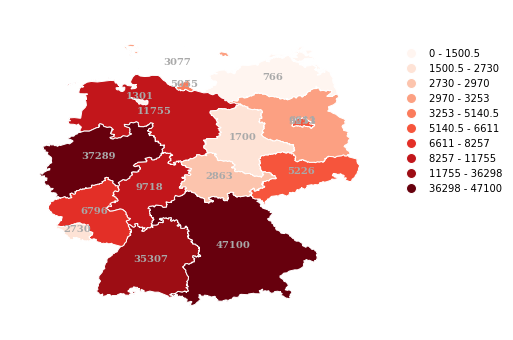

In [28]:
data_pd['confirmed'].fillna(0, inplace = True)
choropleth_administrative_division(data_pd, 'confirmed', add_text=True)

# Plot epidemiology total deaths

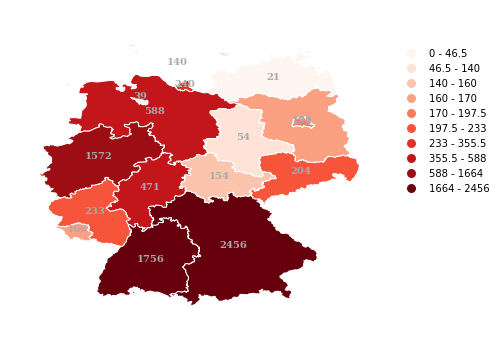

In [29]:
data_pd['dead'].fillna(0, inplace = True)
choropleth_administrative_division(data_pd, 'dead', add_text=True)

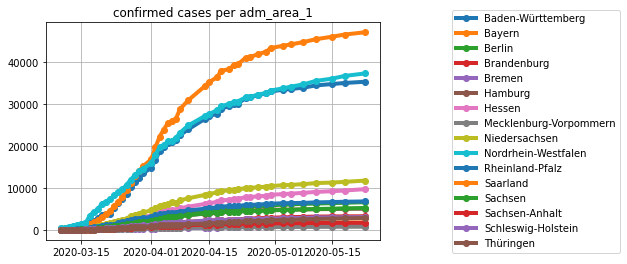

In [30]:
plot_time_series(df, 'confirmed')

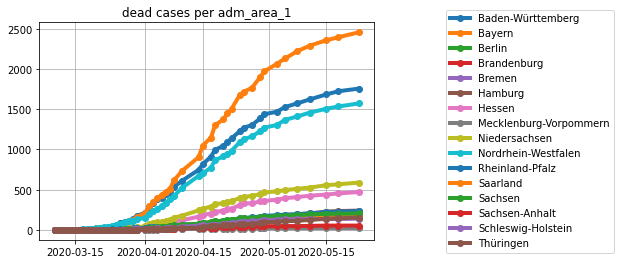

In [31]:
plot_time_series(df, 'dead')